
x1 = "верхний левый угол"  
y1 = "верхний левый угол"  
x2 = "верхний правый угол"  
y2 = "верхний правый угол"  
x3 = "нижний правый угол"  
y3 = "нижний правый угол"  
x4 = "нижний левый угол"  
y4 = "нижний левый угол"  
elevation = "высота"  
inclination = "максимальный угол наклона"  
temp = "температура"  
pressure = "давление"  
humidity = "влажность"  
wind_speed = "скорость ветра"  
wind_gust = "порыв ветра"  
clouds = "облачность"  
weather = "тип погоды"  
bdod =   
cec =   
cfvo =   
clay =   
nitrogen =   
ocd =  
ocs =  
phh2o =  
sand =  
silt =  
soc =  
score =  

Tasks:
1. что делать со строками у которых есть Nan значение

# Создание модели

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
%matplotlib inline
import json
from graphviz  import Source
from IPython.display import SVG, display, HTML
style = "<style>svg{width: 70% !important; height: 60% !important;} </style>"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import os
os.environ["PATH"] += os.pathsep + "C:\\Program Files (x86)\\Graphviz2.38\\bin" + os.pathsep + "C:\\Program Files (x86)\\Graphviz2.38"

In [2]:
PARAMS_FOR_MODEL = ['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'inclination', 'weather', 'elevation', 'wind_gust']


In [3]:
def custom_dummies_weather(df):
    df['weather'] = df['weather'].apply(lambda x: tuple(x))
    weather_data = df.weather
    weather_data = {j for i in weather_data for j in i}
    arr = {}
    for weather_type in WEATHER_TYPES:
        for weather_el in df['weather']:
            if weather_type in weather_el:
                if arr.get(weather_type):
                    arr.get(weather_type).append(1)
                else:
                    arr[weather_type] = [1]
            else:
                if arr.get(weather_type):
                    arr.get(weather_type).append(0)
                else:
                    arr[weather_type] = [0]

    arr = pd.DataFrame.from_dict(arr)
    return arr

In [4]:
def get_weather_types(df):
    df_weather = df['weather'].apply(lambda x: tuple(x))
    weather_types = df_weather.ravel()
    weather_types = {str(i) for i in (np.concatenate(weather_types))}
    return weather_types

In [34]:

frames = [
    pd.DataFrame.from_dict(pd.read_pickle("./datasets/vineyard1.pickle").values()),
    pd.DataFrame.from_dict(pd.read_pickle("./datasets/vineyard2.pickle").values()),
    pd.DataFrame.from_dict(pd.read_pickle("./datasets/vineyard3.pickle").values()),
    pd.DataFrame.from_dict(pd.read_pickle("./datasets/vineyard4.pickle").values()),
    pd.DataFrame.from_dict(pd.read_pickle("./datasets/vineyard5.pickle").values()),
    pd.DataFrame.from_dict(pd.read_pickle("./datasets/vineyard6.pickle").values()),
    pd.DataFrame.from_dict(pd.read_pickle("./datasets/nonvineyard1.pickle").values()),
    pd.DataFrame.from_dict(pd.read_pickle("./datasets/nonvineyard2.pickle").values()),
    pd.DataFrame.from_dict(pd.read_pickle("./datasets/nonvineyard3.pickle").values()),
]
train_df = pd.concat(frames, ignore_index=True)
train_df["growing"] = train_df["growing"].astype(int)
WEATHER_TYPES = get_weather_types(train_df)
WEATHER_TYPES

{'broken clouds',
 'clear sky',
 'few clouds',
 'fog',
 'haze',
 'heavy intensity rain',
 'light rain',
 'light snow',
 'mist',
 'moderate rain',
 'moderate rainmist',
 'overcast clouds',
 'scattered clouds',
 'snow',
 'thunderstorm',
 'very heavy rain'}

In [6]:
custom_dummies_weather(train_df)

,very heavy rain,few clouds,haze,snow,thunderstorm,clear sky,mist,fog,light snow,overcast clouds,moderate rainmist,heavy intensity rain,light rain,broken clouds,scattered clouds,moderate rain
0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,0
1,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,0
2,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,0
3,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,0
4,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13611,0,1,0,1,0,1,0,0,1,1,0,0,1,1,1,0
13612,0,1,0,1,0,1,0,0,1,1,0,0,1,1,1,0
13613,0,1,0,1,0,1,0,0,1,1,0,0,1,1,1,0
13614,0,1,0,1,0,1,0,0,1,1,0,0,1,1,1,0


In [7]:
train_df = pd.concat([train_df, custom_dummies_weather(train_df)], axis=1)


In [8]:
from sklearn.model_selection import train_test_split
train_df = train_df.drop(PARAMS_FOR_MODEL, axis=1)
train_df = train_df.dropna().reset_index(drop=True)
X = train_df.drop(['growing', ], axis=1)
y = train_df.growing
X

,temp,pressure,humidity,wind_speed,clouds,bdod,cec,cfvo,clay,nitrogen,ocd,ocs,phh2o,sand,silt,soc,very heavy rain,few clouds,haze,snow,thunderstorm,clear sky,mist,fog,light snow,overcast clouds,moderate rainmist,heavy intensity rain,light rain,broken clouds,scattered clouds,moderate rain
0,18.95,1021.55,64.72,2.12,28.87,121.0,282.0,178.0,293.0,607.0,545.0,62.0,61.0,276.0,431.0,770.0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,0
1,18.95,1021.55,64.72,2.12,28.87,123.0,277.0,183.0,306.0,620.0,555.0,59.0,65.0,284.0,410.0,589.0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,0
2,18.95,1021.55,64.72,2.12,28.87,124.0,284.0,183.0,290.0,566.0,547.0,59.0,62.0,276.0,434.0,632.0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,0
3,18.95,1021.55,64.72,2.12,28.87,125.0,289.0,190.0,284.0,550.0,536.0,58.0,65.0,278.0,438.0,607.0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,0
4,18.95,1021.55,64.72,2.12,28.87,125.0,289.0,190.0,284.0,550.0,536.0,58.0,65.0,278.0,438.0,607.0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9840,2.89,1012.30,76.61,2.16,79.57,66.0,435.0,141.0,177.0,1032.0,545.0,73.0,63.0,471.0,352.0,2082.0,0,1,0,1,0,1,0,0,1,1,0,0,1,1,1,0
9841,2.89,1012.30,76.61,2.16,79.57,66.0,435.0,141.0,177.0,1032.0,545.0,73.0,63.0,471.0,352.0,2082.0,0,1,0,1,0,1,0,0,1,1,0,0,1,1,1,0
9842,2.89,1012.30,76.61,2.16,79.57,66.0,435.0,141.0,177.0,1032.0,545.0,73.0,63.0,471.0,352.0,2082.0,0,1,0,1,0,1,0,0,1,1,0,0,1,1,1,0
9843,2.89,1012.30,76.61,2.16,79.57,65.0,427.0,156.0,175.0,1063.0,548.0,75.0,63.0,476.0,349.0,2109.0,0,1,0,1,0,1,0,0,1,1,0,0,1,1,1,0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42, stratify=y)
X_train

,temp,pressure,humidity,wind_speed,clouds,bdod,cec,cfvo,clay,nitrogen,ocd,ocs,phh2o,sand,silt,soc,very heavy rain,few clouds,haze,snow,thunderstorm,clear sky,mist,fog,light snow,overcast clouds,moderate rainmist,heavy intensity rain,light rain,broken clouds,scattered clouds,moderate rain
8759,31.39,1012.33,14.57,5.73,1.15,139.0,178.0,237.0,155.0,132.0,105.0,18.0,85.0,604.0,241.0,43.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4971,25.11,1015.43,64.06,3.44,27.21,109.0,394.0,77.0,188.0,1084.0,635.0,70.0,50.0,389.0,423.0,2017.0,0,1,0,0,0,1,1,1,0,1,0,0,0,1,1,0
8843,2.89,1012.30,76.61,2.16,79.57,68.0,459.0,100.0,157.0,990.0,599.0,85.0,62.0,484.0,360.0,2096.0,0,1,0,1,0,1,0,0,1,1,0,0,1,1,1,0
3500,26.72,1016.12,58.28,1.84,23.53,130.0,245.0,124.0,262.0,381.0,410.0,38.0,75.0,298.0,440.0,400.0,1,1,0,0,0,1,0,0,0,1,0,0,1,1,1,1
5677,25.11,1015.43,64.06,3.44,27.21,107.0,389.0,72.0,170.0,1245.0,653.0,70.0,48.0,411.0,419.0,2225.0,0,1,0,0,0,1,1,1,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,24.79,1015.49,64.93,1.80,26.05,107.0,423.0,84.0,139.0,1204.0,657.0,75.0,47.0,432.0,429.0,2032.0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0
3032,17.89,1006.41,72.67,5.26,53.01,151.0,232.0,75.0,315.0,279.0,362.0,46.0,61.0,266.0,418.0,402.0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0
8553,31.39,1012.33,14.57,5.73,1.15,139.0,177.0,189.0,151.0,138.0,108.0,23.0,85.0,595.0,254.0,45.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
5685,25.45,1015.44,63.57,3.41,27.23,113.0,383.0,55.0,155.0,1019.0,565.0,68.0,52.0,463.0,382.0,1453.0,0,1,0,0,0,1,1,1,0,1,0,0,0,1,1,0


In [10]:
X_train.isnull().sum()

temp                    0
pressure                0
humidity                0
wind_speed              0
clouds                  0
bdod                    0
cec                     0
cfvo                    0
clay                    0
nitrogen                0
ocd                     0
ocs                     0
phh2o                   0
sand                    0
silt                    0
soc                     0
very heavy rain         0
few clouds              0
haze                    0
snow                    0
thunderstorm            0
clear sky               0
mist                    0
fog                     0
light snow              0
overcast clouds         0
moderate rainmist       0
heavy intensity rain    0
light rain              0
broken clouds           0
scattered clouds        0
moderate rain           0
dtype: int64

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
params = {'n_estimators': range(10, 300, 10), 'max_depth': range(1, 10)}
grid_search_cv_rfc = GridSearchCV(rfc, params, cv=5)

In [12]:
grid_search_cv_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': range(10, 300, 10)})

In [13]:
best_clf = grid_search_cv_rfc.best_estimator_
n_estimators_rfc = grid_search_cv_rfc.best_params_['n_estimators']
grid_search_cv_rfc.best_params_

{'max_depth': 1, 'n_estimators': 50}

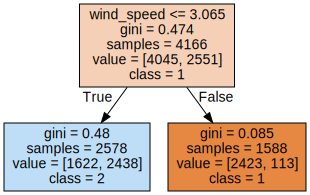

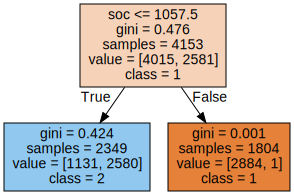

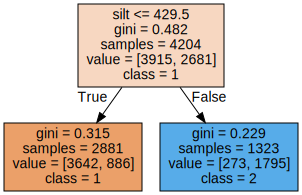

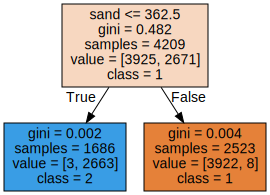

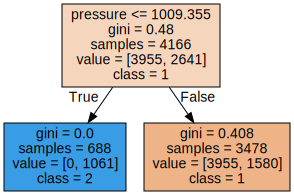

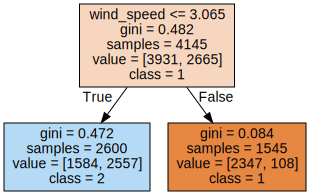

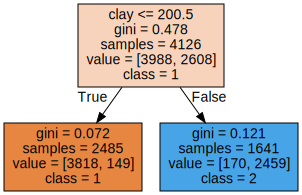

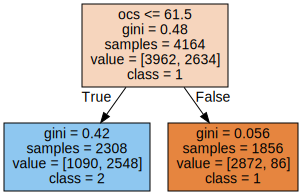

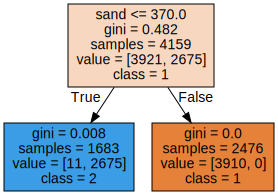

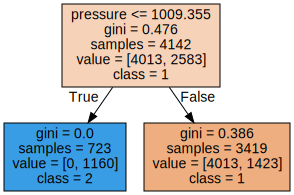

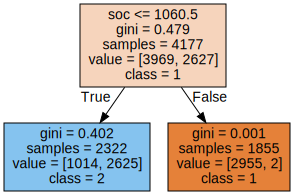

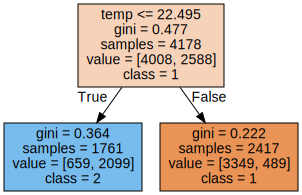

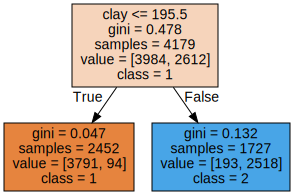

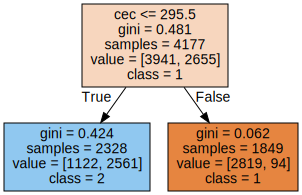

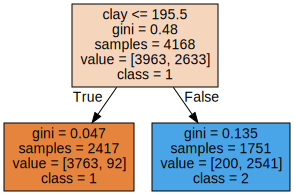

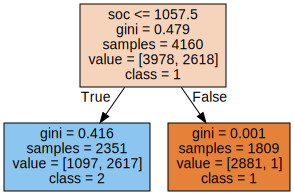

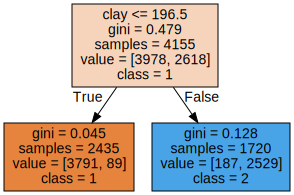

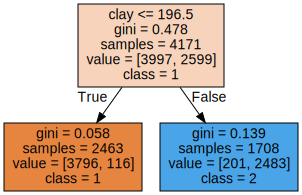

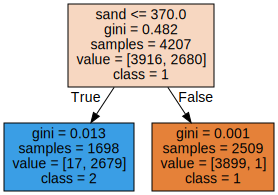

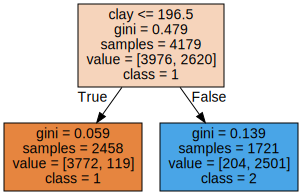

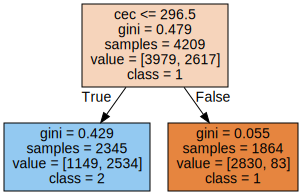

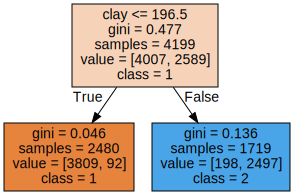

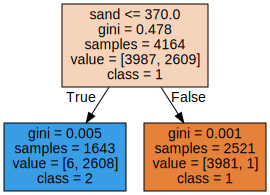

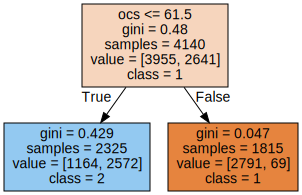

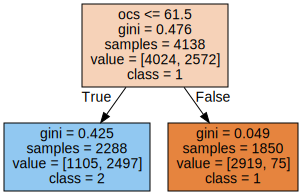

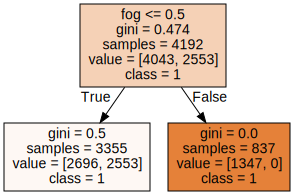

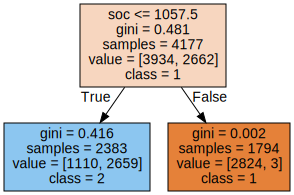

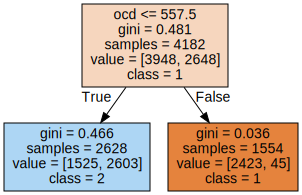

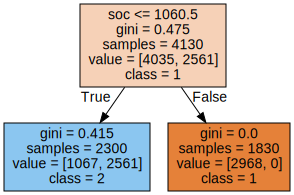

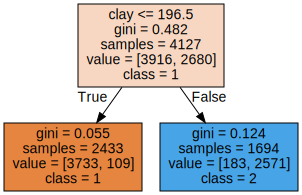

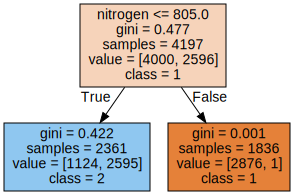

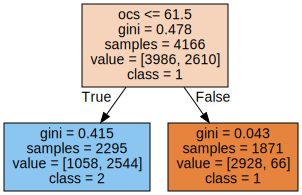

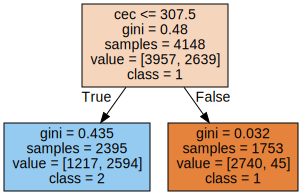

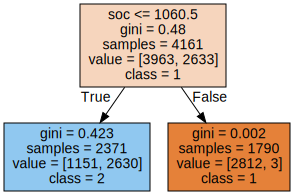

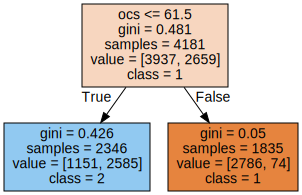

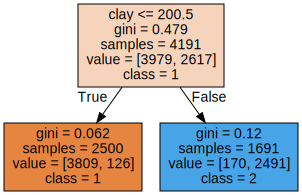

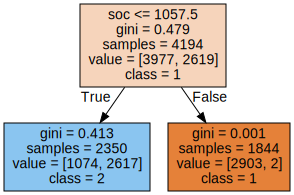

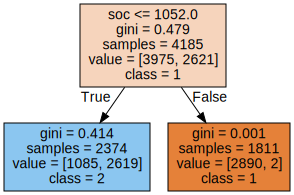

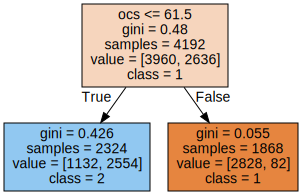

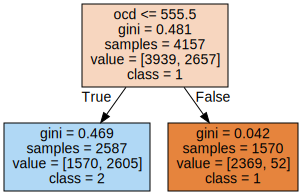

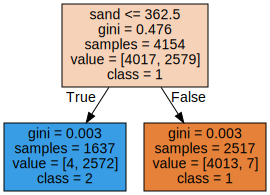

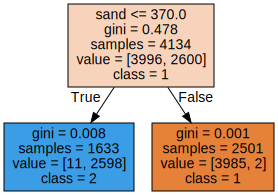

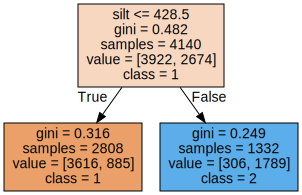

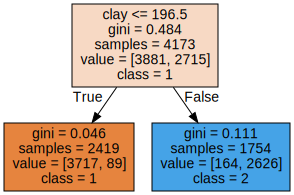

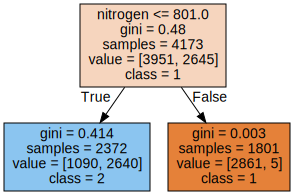

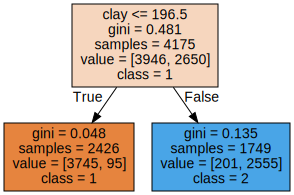

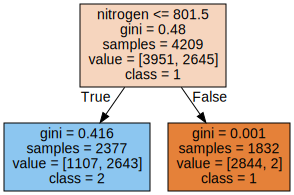

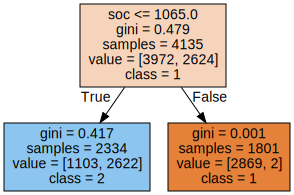

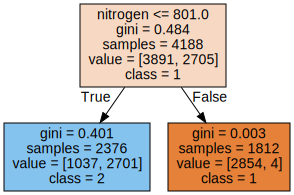

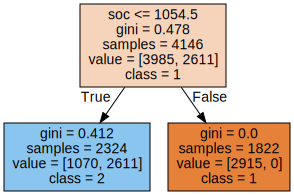

In [14]:
for i in range(0, n_estimators_rfc):
    graph = Source(tree.export_graphviz(best_clf[i], out_file=None, feature_names=list(X), class_names=['1', '2'], filled=True))
    display(SVG(graph.pipe(format='svg')))


Кросс валидация

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(best_clf, X_test, y_test, cv=5, scoring='accuracy')

array([1., 1., 1., 1., 1.])

In [16]:
std_scores = [cross_val_score(best_clf[i], X_test, y_test, cv=5).std() for i in range(0, n_estimators_rfc)]
cross_val_score(best_clf, X_test, y_test, cv=5).std()

0.0

ROC

In [17]:
from sklearn.metrics import precision_score
precision_score(y_test, best_clf.predict(X_test))

1.0

ROLL

In [18]:
from sklearn.metrics import recall_score
recall_score(y_test, best_clf.predict(X_test))

1.0

Сохранение модели

In [35]:
with open("./models/model.pkl", "wb") as f:
    pickle.dump(best_clf, f)

Получение скоринга

<Axes: >

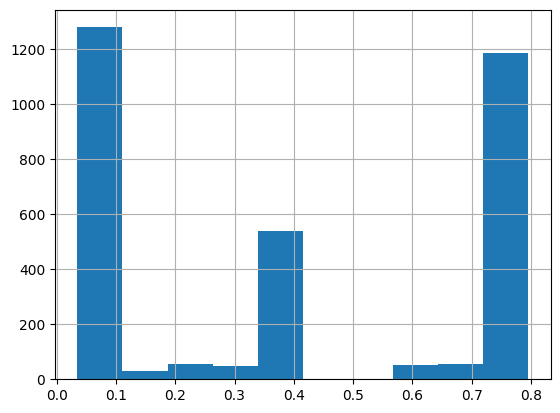

In [37]:
predicted_prob = best_clf.predict_proba(X_test)
pd.Series(predicted_prob[:, 1]).hist()

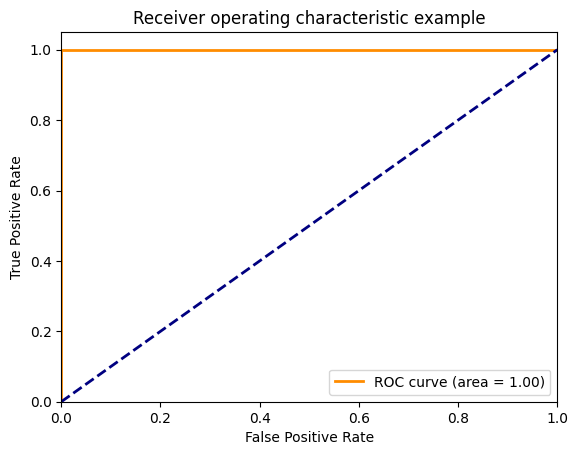

In [38]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Самые важные Features

In [39]:
feature_importances = best_clf.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train),
                                      'feature_importances': feature_importances})
feature_importances_df.sort_values('feature_importances', ascending=False)

,features,feature_importances
8,clay,0.22
15,soc,0.20
11,ocs,0.12
13,sand,0.12
9,nitrogen,0.08
6,cec,0.06
10,ocd,0.04
3,wind_speed,0.04
1,pressure,0.04
14,silt,0.04


In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1954
           1       1.00      1.00      1.00      1295

    accuracy                           1.00      3249
   macro avg       1.00      1.00      1.00      3249
weighted avg       1.00      1.00      1.00      3249



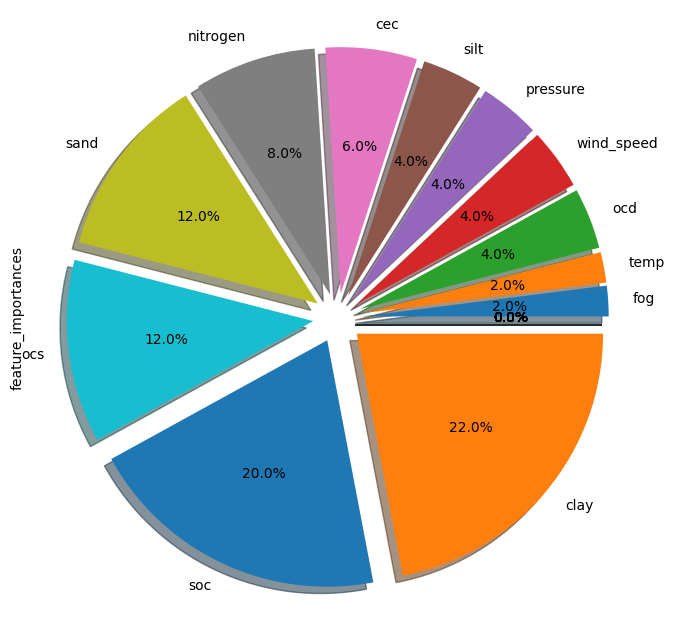

In [41]:

feature_importances_df = pd.DataFrame({'features':list(X_train.columns), 
                                       'feature_importances':  feature_importances})\
                        .sort_values(by='feature_importances')

feature_importances_df.plot.pie(
                        explode=[0.1]*len(X_train.columns),
                        labels = feature_importances_df.features,
                        y = 'feature_importances',
                        autopct='%1.1f%%',
                        shadow=True,
                        legend=False,
                        figsize=(8, 8));

# Получение предсказание

In [68]:
PATH = "./datasets/dataset.pickle"
df = pd.DataFrame.from_dict(pd.read_pickle(PATH).values())
lat_lng = pd.DataFrame.from_dict(pd.read_pickle(PATH).keys()).rename(columns={0: "lat", 1: "lng"})
lat_lng

,lat,lng
0,44.914533,38.945518
1,44.914533,38.947768
2,44.914533,38.950018
3,44.914533,38.952268
4,44.914533,38.954518
...,...,...
1635,44.824533,39.024268
1636,44.824533,39.026518
1637,44.824533,39.028768
1638,44.824533,39.031018


In [69]:
db_attr = df[PARAMS_FOR_MODEL]

In [70]:
df = pd.concat([df, custom_dummies_weather(df)], axis=1)
df = df.drop(PARAMS_FOR_MODEL, axis=1)
df = df.dropna().reset_index(drop=True)
df

,temp,pressure,humidity,wind_speed,clouds,bdod,cec,cfvo,clay,nitrogen,ocd,ocs,phh2o,sand,silt,soc,very heavy rain,few clouds,haze,snow,thunderstorm,clear sky,mist,fog,light snow,overcast clouds,moderate rainmist,heavy intensity rain,light rain,broken clouds,scattered clouds,moderate rain
0,24.54,1013.16,44.43,2.94,4.64,125.0,284.0,149.0,402.0,591.0,431.0,69.0,64.0,267.0,331.0,633.0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0
1,24.54,1013.16,44.43,2.94,4.64,125.0,284.0,149.0,402.0,591.0,431.0,69.0,64.0,267.0,331.0,633.0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0
2,24.54,1013.16,44.43,2.94,4.64,127.0,288.0,132.0,394.0,496.0,411.0,66.0,65.0,267.0,339.0,541.0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0
3,24.54,1013.16,44.43,2.94,4.64,128.0,275.0,127.0,388.0,425.0,404.0,64.0,64.0,265.0,347.0,497.0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0
4,24.54,1013.16,44.43,2.94,4.64,127.0,275.0,128.0,381.0,449.0,408.0,66.0,64.0,270.0,349.0,518.0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,23.13,1013.23,51.24,2.69,3.88,123.0,279.0,124.0,364.0,538.0,436.0,61.0,64.0,342.0,294.0,551.0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0
1592,23.13,1013.23,51.24,2.69,3.88,116.0,280.0,148.0,336.0,718.0,433.0,69.0,59.0,299.0,365.0,791.0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0
1593,23.13,1013.23,51.24,2.69,3.88,116.0,280.0,148.0,336.0,718.0,433.0,69.0,59.0,299.0,365.0,791.0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0
1594,23.13,1013.23,51.24,2.69,3.88,117.0,273.0,136.0,332.0,642.0,428.0,69.0,61.0,294.0,374.0,823.0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0


In [71]:
predicted = best_clf.predict_proba(df)
predicted

array([[0.3529693, 0.6470307],
       [0.3529693, 0.6470307],
       [0.3529693, 0.6470307],
       ...,
       [0.3529693, 0.6470307],
       [0.3529693, 0.6470307],
       [0.3529693, 0.6470307]])

In [72]:
series_score = pd.Series(predicted[:, 1], name='score').apply(lambda x: x*100)
series_score

0       64.703070
1       64.703070
2       64.703070
3       64.703070
4       64.703070
          ...    
1591    72.740638
1592    64.703070
1593    64.703070
1594    64.703070
1595    64.703070
Name: score, Length: 1596, dtype: float64

<Axes: >

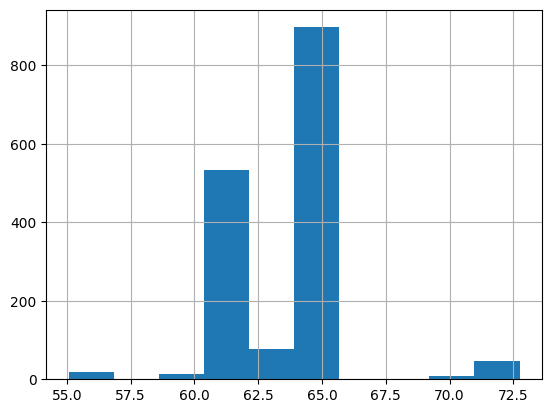

In [73]:
series_score.hist()

In [74]:
df = pd.concat([df, series_score, lat_lng, db_attr], axis=1)
df = df.replace({np.nan:None})
df

,temp,pressure,humidity,wind_speed,clouds,bdod,cec,cfvo,clay,nitrogen,ocd,ocs,phh2o,sand,silt,soc,very heavy rain,few clouds,haze,snow,thunderstorm,clear sky,mist,fog,light snow,overcast clouds,moderate rainmist,heavy intensity rain,light rain,broken clouds,scattered clouds,moderate rain,score,lat,lng,x1,y1,x2,y2,x3,y3,x4,y4,inclination,weather,elevation,wind_gust
0,24.54,1013.16,44.43,2.94,4.64,125.0,284.0,149.0,402.0,591.0,431.0,69.0,64.0,267.0,331.0,633.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,64.70307,44.914533,38.945518,38.944393,44.913408,38.946643,44.913408,38.944393,44.915658,38.946643,44.915658,0.916654,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",23,4.65
1,24.54,1013.16,44.43,2.94,4.64,125.0,284.0,149.0,402.0,591.0,431.0,69.0,64.0,267.0,331.0,633.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,64.70307,44.914533,38.947768,38.946643,44.913408,38.948893,44.913408,38.946643,44.915658,38.948893,44.915658,1.83284,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",24,4.65
2,24.54,1013.16,44.43,2.94,4.64,127.0,288.0,132.0,394.0,496.0,411.0,66.0,65.0,267.0,339.0,541.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,64.70307,44.914533,38.950018,38.948893,44.913408,38.951143,44.913408,38.948893,44.915658,38.951143,44.915658,0.916654,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",24,4.65
3,24.54,1013.16,44.43,2.94,4.64,128.0,275.0,127.0,388.0,425.0,404.0,64.0,64.0,265.0,347.0,497.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,64.70307,44.914533,38.952268,38.951143,44.913408,38.953393,44.913408,38.951143,44.915658,38.953393,44.915658,1.83284,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",26,4.65
4,24.54,1013.16,44.43,2.94,4.64,127.0,275.0,128.0,381.0,449.0,408.0,66.0,64.0,270.0,349.0,518.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,64.70307,44.914533,38.954518,38.953393,44.913408,38.955643,44.913408,38.953393,44.915658,38.955643,44.915658,1.374835,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",23,4.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,44.824533,39.024268,39.023143,44.823408,39.025393,44.823408,39.023143,44.825658,39.025393,44.825658,1.374835,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",45,3.86
1636,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,44.824533,39.026518,39.025393,44.823408,39.027643,44.823408,39.025393,44.825658,39.027643,44.825658,1.374835,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",46,3.86
1637,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,44.824533,39.028768,39.027643,44.823408,39.029893,44.823408,39.027643,44.825658,39.029893,44.825658,2.29061,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",49,3.86
1638,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,44.824533,39.031018,39.029893,44.823408,39.032143,44.823408,39.029893,44.825658,39.032143,44.825658,2.29061,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",44,3.86


In [75]:
def score_feather_inclination(df):
    '''
    Выставление оценки в зависимости от наклона полигона
    :param df:
    :return:
    '''
    df.loc[df.inclination > 1.0, 'score'] = 0
score_feather_inclination(df)
df

,temp,pressure,humidity,wind_speed,clouds,bdod,cec,cfvo,clay,nitrogen,ocd,ocs,phh2o,sand,silt,soc,very heavy rain,few clouds,haze,snow,thunderstorm,clear sky,mist,fog,light snow,overcast clouds,moderate rainmist,heavy intensity rain,light rain,broken clouds,scattered clouds,moderate rain,score,lat,lng,x1,y1,x2,y2,x3,y3,x4,y4,inclination,weather,elevation,wind_gust
0,24.54,1013.16,44.43,2.94,4.64,125.0,284.0,149.0,402.0,591.0,431.0,69.0,64.0,267.0,331.0,633.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,64.70307,44.914533,38.945518,38.944393,44.913408,38.946643,44.913408,38.944393,44.915658,38.946643,44.915658,0.916654,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",23,4.65
1,24.54,1013.16,44.43,2.94,4.64,125.0,284.0,149.0,402.0,591.0,431.0,69.0,64.0,267.0,331.0,633.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,44.914533,38.947768,38.946643,44.913408,38.948893,44.913408,38.946643,44.915658,38.948893,44.915658,1.83284,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",24,4.65
2,24.54,1013.16,44.43,2.94,4.64,127.0,288.0,132.0,394.0,496.0,411.0,66.0,65.0,267.0,339.0,541.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,64.70307,44.914533,38.950018,38.948893,44.913408,38.951143,44.913408,38.948893,44.915658,38.951143,44.915658,0.916654,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",24,4.65
3,24.54,1013.16,44.43,2.94,4.64,128.0,275.0,127.0,388.0,425.0,404.0,64.0,64.0,265.0,347.0,497.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,44.914533,38.952268,38.951143,44.913408,38.953393,44.913408,38.951143,44.915658,38.953393,44.915658,1.83284,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",26,4.65
4,24.54,1013.16,44.43,2.94,4.64,127.0,275.0,128.0,381.0,449.0,408.0,66.0,64.0,270.0,349.0,518.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,44.914533,38.954518,38.953393,44.913408,38.955643,44.913408,38.953393,44.915658,38.955643,44.915658,1.374835,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",23,4.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,44.824533,39.024268,39.023143,44.823408,39.025393,44.823408,39.023143,44.825658,39.025393,44.825658,1.374835,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",45,3.86
1636,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,44.824533,39.026518,39.025393,44.823408,39.027643,44.823408,39.025393,44.825658,39.027643,44.825658,1.374835,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",46,3.86
1637,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,44.824533,39.028768,39.027643,44.823408,39.029893,44.823408,39.027643,44.825658,39.029893,44.825658,2.29061,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",49,3.86
1638,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,44.824533,39.031018,39.029893,44.823408,39.032143,44.823408,39.029893,44.825658,39.032143,44.825658,2.29061,"{few clouds, clear sky, overcast clouds, broken clouds, scattered clouds}",44,3.86


In [76]:
df.isnull().sum()

temp                    44
pressure                44
humidity                44
wind_speed              44
clouds                  44
bdod                    44
cec                     44
cfvo                    44
clay                    44
nitrogen                44
ocd                     44
ocs                     44
phh2o                   44
sand                    44
silt                    44
soc                     44
very heavy rain         44
few clouds              44
haze                    44
snow                    44
thunderstorm            44
clear sky               44
mist                    44
fog                     44
light snow              44
overcast clouds         44
moderate rainmist       44
heavy intensity rain    44
light rain              44
broken clouds           44
scattered clouds        44
moderate rain           44
score                   21
lat                      0
lng                      0
x1                       0
y1                       0
x

In [77]:
df.to_pickle("./datasets/map1.pickle")  